In [2]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [5]:
import os
print(os.listdir(r'E:\rohan\rethink\TRAIN'))

['augmented_data', 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [6]:
X = []
y = []

IMG_SIZE = 150

BUILDING_DIR = r'E:\rohan\rethink\TRAIN\buildings'
FOREST_DIR = r'E:\rohan\rethink\TRAIN\forest'
GLACIER_DIR = r'E:\rohan\rethink\TRAIN\glacier'
MOUNTAIN_DIR = r'E:\rohan\rethink\TRAIN\mountain'
SEA_DIR = r'E:\rohan\rethink\TRAIN\sea'
STREET_DIR = r'E:\rohan\rethink\TRAIN\street'


In [7]:
def assigning_label(img,image_type):
    return image_type

In [8]:

def make_train_data(image_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assigning_label(img,image_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [9]:
#create training data
make_train_data('buildings',BUILDING_DIR)
make_train_data('forest',FOREST_DIR)
make_train_data('glacier',GLACIER_DIR)
make_train_data('mountain',MOUNTAIN_DIR)
make_train_data('sea',SEA_DIR)
make_train_data('street',STREET_DIR)

print(len(X))

100%|██████████████████████████████████████████████████| 2306/2306 [00:05<00:00, 391.69it/s]

13625


In [10]:
len(y)

13625

In [11]:
y[1000]

'buildings'

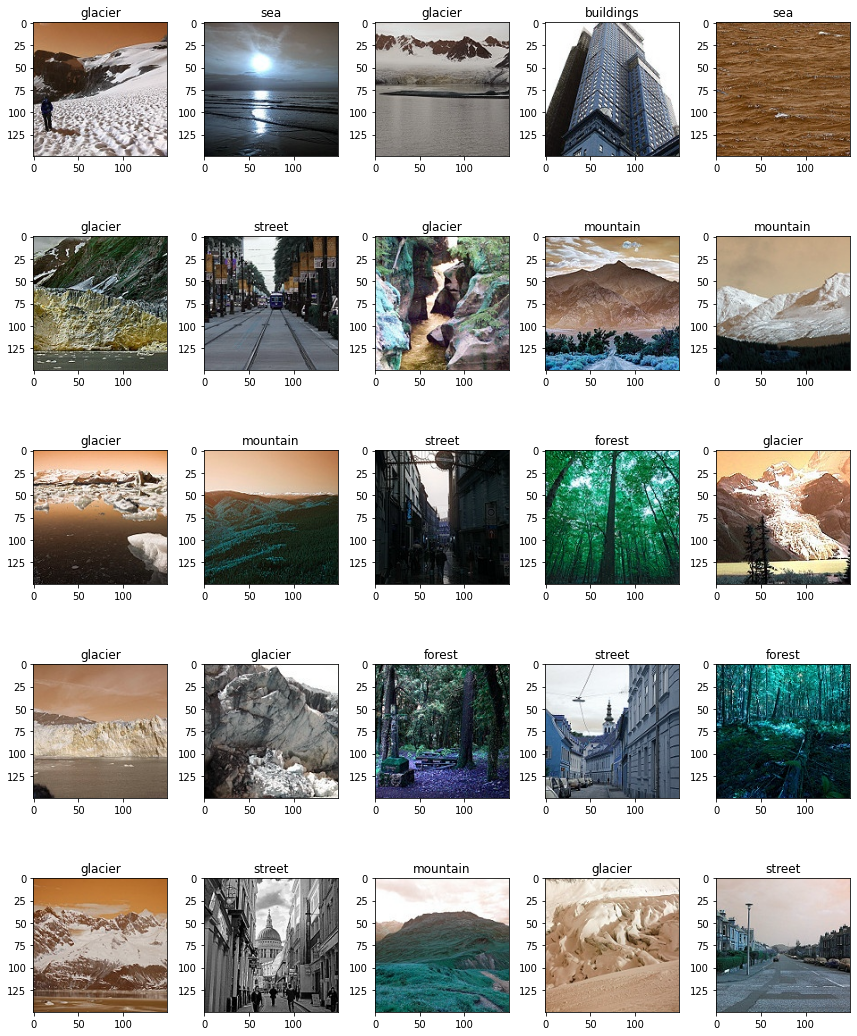

In [12]:
import random as rn

fig,ax = plt.subplots(5,5)
fig.set_size_inches(12,15)

for i in range(5):
    for j in range (5):
        l = rn.randint(0, len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(y[l])
        
plt.tight_layout()

Text(0.5, 1.0, 'IMAGE : buildings')

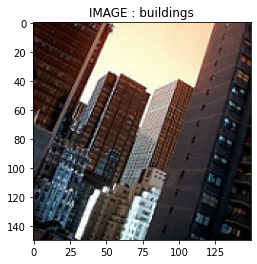

In [13]:
n = 100
plt.imshow(X[n])
plt.title(f"IMAGE : {y[n]}")

In [14]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)
X = np.array(X)
X = X/255

In [15]:
y

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [16]:
y = keras.utils.to_categorical(y,6)

In [17]:
y.shape

(13625, 6)

In [18]:
X.shape

(13625, 150, 150, 3)

In [6]:
IMAGE_SIZE = [150, 150]

In [7]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [9]:
# useful for getting number of classes
folders = glob('E:/rohan/rethink/TRAIN/augmented_data/*')
print(len(folders))

6


In [10]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [11]:
from keras import optimizers

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

In [22]:
# Data Augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [23]:
# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory(r'E:/rohan/rethink/TRAIN/augmented_data',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                subset = 'training',
                                                 class_mode = 'categorical')

Found 48000 images belonging to 6 classes.


In [24]:
val_set = train_datagen.flow_from_directory(r'E:/rohan/rethink/TRAIN/augmented_data',
                                            target_size = (150, 150),
                                            batch_size = 64,
                                           subset = 'validation',
                                            class_mode = 'categorical')

Found 12000 images belonging to 6 classes.


In [25]:
test_ds = test_datagen.flow_from_directory(
    directory=r'E:\rohan\rethink\.',
    batch_size = 7,
    seed = 42,
    shuffle = False,
    classes = ['test'],
    target_size = (150,150)
)

Found 3409 images belonging to 1 classes.


In [17]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath='2vgg16.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(train_set,
                    validation_data=val_set,
                    epochs=30,
                    steps_per_epoch=1000,
                    validation_steps=500,
                    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/30
1000/1000 [==============================] - 796s 796ms/step - loss: 6.6185 - accuracy: 0.6227 - val_loss: 6.4438 - val_accuracy: 0.6474

Epoch 00001: val_loss improved from inf to 6.44377, saving model to 2vgg16.h5
Epoch 2/30
1000/1000 [==============================] - 501s 501ms/step - loss: 6.8755 - accuracy: 0.6581 - val_loss: 6.8230 - val_accuracy: 0.6566

Epoch 00002: val_loss did not improve from 6.44377
Epoch 3/30
1000/1000 [==============================] - 243s 243ms/step - loss: 6.3879 - accuracy: 0.6759 - val_loss: 5.7396 - val_accuracy: 0.6656

Epoch 00003: val_loss improved from 6.44377 to 5.73955, saving model to 2vgg16.h5
Epoch 4/30
1000/1000 [==============================] - 270s 270ms/step - loss: 5.9727 - accuracy: 0.6933 - val_loss: 12.2571 - val_accuracy: 0.6630

Epoch 00004: val_loss did not improve from 5.73955
Epoch 5/30
1000/1000 [==============================] - 246s 246ms/step - loss: 6.6083 - accuracy: 0.6831 - val_loss: 4.9686 - val_accuracy:

c:\users\rohan\anaconda3\envs\flower\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


1000/1000 [==============================] - 1517s 2s/step - loss: 4.7489 - accuracy: 0.7504 - val_loss: 5.5497 - val_accuracy: 0.6607

Epoch 00016: val_loss did not improve from 4.96865
Epoch 17/30
1000/1000 [==============================] - 872s 872ms/step - loss: 5.4841 - accuracy: 0.7316 - val_loss: 14.3949 - val_accuracy: 0.6575

Epoch 00017: val_loss did not improve from 4.96865
Epoch 18/30
1000/1000 [==============================] - 448s 448ms/step - loss: 4.7764 - accuracy: 0.7460 - val_loss: 12.8845 - val_accuracy: 0.6585

Epoch 00018: val_loss did not improve from 4.96865
Epoch 19/30
1000/1000 [==============================] - 347s 347ms/step - loss: 4.9702 - accuracy: 0.7450 - val_loss: 8.3447 - val_accuracy: 0.6663

Epoch 00019: val_loss did not improve from 4.96865
Epoch 20/30
1000/1000 [==============================] - 247s 247ms/step - loss: 5.0268 - accuracy: 0.7396 - val_loss: 14.6314 - val_accuracy: 0.6560

Epoch 00020: val_loss did not improve from 4.96865
Epoch 

In [20]:
import pandas as pd

#prediction 
test_ds.reset()
pred = model.predict_generator(test_ds,verbose=1)

predicted_class_indices = np.argmax(pred,axis=1)

labels = (train_set.class_indices)

labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]
filenames = test_ds.filenames
filen = [name[5:] for name in filenames]
results = pd.DataFrame({"filename":filen,
                      "class":predictions})

results.to_csv("result.csv",index=False)

In [ ]:
checkpoint = ModelCheckpoint(filepath='3vgg16.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(train_set,
                    validation_data=val_set,
                    epochs=30,
                    steps_per_epoch=2000,
                    validation_steps=500,
                    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
2000/2000 [==============================] - 370s 185ms/step - loss: 4.3772 - accuracy: 0.7655 - val_loss: 9.7700 - val_accuracy: 0.7152

Epoch 00001: val_loss improved from inf to 9.77001, saving model to 3vgg16.h5
Epoch 2/30
2000/2000 [==============================] - 508s 254ms/step - loss: 4.4075 - accuracy: 0.7646 - val_loss: 7.5638 - val_accuracy: 0.7059

Epoch 00002: val_loss improved from 9.77001 to 7.56382, saving model to 3vgg16.h5
Epoch 3/30
2000/2000 [==============================] - 695s 347ms/step - loss: 4.3412 - accuracy: 0.7646 - val_loss: 10.4613 - val_accuracy: 0.7018

Epoch 00003: val_loss did not improve from 7.56382
Epoch 4/30
2000/2000 [==============================] - 804s 402ms/step - loss: 4.0775 - accuracy: 0.7739 - val_loss: 13.9611 - val_accuracy: 0.6971

Epoch 00004: val_loss did not improve from 7.56382
Epoch 5/30
2000/2000 [==============================] - 488s 244ms/step - loss: 4.1017 - accuracy: 0.7724 - val_loss: 12.2609 - val_accuracy

In [ ]:
#prediction 
test_ds.reset()
pred = model.predict_generator(test_ds,verbose=1)

predicted_class_indices = np.argmax(pred,axis=1)

labels = (train_set.class_indices)

labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]
filenames = test_ds.filenames
filen = [name[5:] for name in filenames]
results = pd.DataFrame({"filename":filen,
                      "class":predictions})

results.to_csv("result2.csv",index=False)

In [ ]:
checkpoint = ModelCheckpoint(filepath='4vgg16.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(train_set,
                    validation_data=val_set,
                    epochs=30,
                    steps_per_epoch=3000,
                    validation_steps=500,
                    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
#prediction 
test_ds.reset()
pred = model.predict_generator(test_ds,verbose=1)

predicted_class_indices = np.argmax(pred,axis=1)

labels = (train_set.class_indices)

labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]
filenames = test_ds.filenames
filen = [name[5:] for name in filenames]
results = pd.DataFrame({"filename":filen,
                      "class":predictions})

results.to_csv("result3.csv",index=False)

In [32]:
test_ds

SyntaxError: invalid syntax (<ipython-input-32-bace8b9949a0>, line 1)

In [33]:
test_ds.reset()

In [34]:
pred = model.predict_generator(test_ds,verbose=1)

487/487 [==============================] - 64s 132ms/step


In [35]:
pred

array([[9.3170386e-03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 9.9068296e-01],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.2710621e-22, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [36]:
predicted_class_indices = np.argmax(pred,axis=1)

In [37]:
labels = (train_set.class_indices)

In [38]:
predicted_class_indices

array([5, 1, 1, ..., 5, 5, 2], dtype=int64)

In [39]:
labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [40]:
labels = dict((v,k) for k,v in labels.items())

In [41]:
labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [42]:
predictions = [labels[k] for k in predicted_class_indices]

In [43]:
predictions

['street',
 'forest',
 'forest',
 'sea',
 'street',
 'sea',
 'sea',
 'street',
 'sea',
 'buildings',
 'mountain',
 'buildings',
 'mountain',
 'sea',
 'buildings',
 'forest',
 'sea',
 'mountain',
 'buildings',
 'glacier',
 'mountain',
 'buildings',
 'buildings',
 'glacier',
 'mountain',
 'forest',
 'street',
 'street',
 'street',
 'sea',
 'buildings',
 'mountain',
 'glacier',
 'forest',
 'glacier',
 'mountain',
 'buildings',
 'glacier',
 'forest',
 'mountain',
 'sea',
 'sea',
 'street',
 'forest',
 'forest',
 'mountain',
 'street',
 'mountain',
 'street',
 'street',
 'sea',
 'forest',
 'glacier',
 'forest',
 'glacier',
 'forest',
 'forest',
 'buildings',
 'glacier',
 'street',
 'street',
 'forest',
 'forest',
 'street',
 'sea',
 'forest',
 'street',
 'forest',
 'sea',
 'buildings',
 'sea',
 'buildings',
 'sea',
 'glacier',
 'mountain',
 'glacier',
 'forest',
 'sea',
 'buildings',
 'sea',
 'mountain',
 'street',
 'street',
 'mountain',
 'forest',
 'buildings',
 'forest',
 'street',
 'gla

In [44]:
filenames = test_ds.filenames

In [45]:
filenames

['test\\0000.jpg',
 'test\\0001.jpg',
 'test\\0002.jpg',
 'test\\0003.jpg',
 'test\\0004.jpg',
 'test\\0005.jpg',
 'test\\0006.jpg',
 'test\\0007.jpg',
 'test\\0008.jpg',
 'test\\0009.jpg',
 'test\\0010.jpg',
 'test\\0011.jpg',
 'test\\0012.jpg',
 'test\\0013.jpg',
 'test\\0014.jpg',
 'test\\0015.jpg',
 'test\\0016.jpg',
 'test\\0017.jpg',
 'test\\0018.jpg',
 'test\\0019.jpg',
 'test\\0020.jpg',
 'test\\0021.jpg',
 'test\\0022.jpg',
 'test\\0023.jpg',
 'test\\0024.jpg',
 'test\\0025.jpg',
 'test\\0026.jpg',
 'test\\0027.jpg',
 'test\\0028.jpg',
 'test\\0029.jpg',
 'test\\0030.jpg',
 'test\\0031.jpg',
 'test\\0032.jpg',
 'test\\0033.jpg',
 'test\\0034.jpg',
 'test\\0035.jpg',
 'test\\0036.jpg',
 'test\\0037.jpg',
 'test\\0038.jpg',
 'test\\0039.jpg',
 'test\\0040.jpg',
 'test\\0041.jpg',
 'test\\0042.jpg',
 'test\\0043.jpg',
 'test\\0044.jpg',
 'test\\0045.jpg',
 'test\\0046.jpg',
 'test\\0047.jpg',
 'test\\0048.jpg',
 'test\\0049.jpg',
 'test\\0050.jpg',
 'test\\0051.jpg',
 'test\\0052

In [46]:
filen = [name[5:] for name in filenames]

In [47]:
filen

['0000.jpg',
 '0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0006.jpg',
 '0007.jpg',
 '0008.jpg',
 '0009.jpg',
 '0010.jpg',
 '0011.jpg',
 '0012.jpg',
 '0013.jpg',
 '0014.jpg',
 '0015.jpg',
 '0016.jpg',
 '0017.jpg',
 '0018.jpg',
 '0019.jpg',
 '0020.jpg',
 '0021.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0025.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0030.jpg',
 '0031.jpg',
 '0032.jpg',
 '0033.jpg',
 '0034.jpg',
 '0035.jpg',
 '0036.jpg',
 '0037.jpg',
 '0038.jpg',
 '0039.jpg',
 '0040.jpg',
 '0041.jpg',
 '0042.jpg',
 '0043.jpg',
 '0044.jpg',
 '0045.jpg',
 '0046.jpg',
 '0047.jpg',
 '0048.jpg',
 '0049.jpg',
 '0050.jpg',
 '0051.jpg',
 '0052.jpg',
 '0053.jpg',
 '0054.jpg',
 '0055.jpg',
 '0056.jpg',
 '0057.jpg',
 '0058.jpg',
 '0059.jpg',
 '0060.jpg',
 '0061.jpg',
 '0062.jpg',
 '0063.jpg',
 '0064.jpg',
 '0065.jpg',
 '0066.jpg',
 '0067.jpg',
 '0068.jpg',
 '0069.jpg',
 '0070.jpg',
 '0071.jpg',
 '0072.jpg',
 '0073.jpg',
 '0074.jpg',
 '0075.jpg',
 '0076.jpg',

In [57]:
import pandas as pd
results = pd.DataFrame({"FILENAME":filen,
                      "CLASS":predictions})

results.to_csv("result.csv",index=False)

In [61]:
results

,FILENAME,CLASS
0,0000.jpg,street
1,0001.jpg,forest
2,0002.jpg,forest
3,0003.jpg,sea
4,0004.jpg,street
...,...,...
3404,3404.jpg,street
3405,3405.jpg,mountain
3406,3406.jpg,street
3407,3407.jpg,street


In [59]:
results['class'].value_counts()

KeyError: 'class'

In [60]:
results[results['class']=='buildings']

KeyError: 'class'